In [92]:
import check
import pickle
import rockfish as rf
import rockfish.labs as rl
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import glob

In [166]:
def generate_reports(src_file_path, syn_file_path, show_plot=False, show_report=False, interested_features=None, compute_best_feat = False, has_timestamp = False, regress=False):
    
    def plot_features(feature_nums):
        for ft in feature_nums:
            feature = f'feature_{ft}'
            
            fig, ax = plt.subplots()
            fig.set_figwidth(15)
            x = source_data.table["timestamp"]
            y1 = source_data.table[feature]
            y2 = syn_data.table[feature]
            
            min_len = min(len(x), len(y1), len(y2))
            
            x = x[-min_len:]
            y1 = y1[-min_len:]
            y2 = y2[-min_len:]
            
            if regress:
                x = pd.to_datetime(x)
                x = x.astype(np.int64) // 10**9
            
            ax.plot(x, y1, "g", label="True Value")
            ax.plot(x, y2, "b", label="Synthetic Value")
            
            # Calculate and plot the linear regression line for the true values
            # change x to units
            if regress:
                coeffs_true = np.polyfit(x, y1, 1)
                linear_fit_true = np.poly1d(coeffs_true)
                ax.plot(x, linear_fit_true(x), "g--", label="True Value Linear Fit")
                
                # Calculate and plot the linear regression line for the synthetic values
                coeffs_syn = np.polyfit(x, y2, 1)
                linear_fit_syn = np.poly1d(coeffs_syn)
                ax.plot(x, linear_fit_syn(x), "b--", label="Synthetic Value Linear Fit")
            
            plt.title(feature)
            plt.legend()
            plt.show()
        
    
    source_path = src_file_path
    if not syn_file_path:
        syn_path = f'syn_{source_path}'
    else:
        syn_path = syn_file_path
    source = pd.read_csv(source_path)
    syn = pd.read_csv(syn_path)
    if not has_timestamp:
        timestamp_path = source_path.replace('.csv', '_timestamp.csv')
        ts = pd.read_csv(timestamp_path)
        source['timestamp'] = ts['timestamp']
        syn['timestamp'] = ts['timestamp'] 
    
    source_data = rf.Dataset.from_pandas("source", source)
    syn_data = rf.Dataset.from_pandas("syn", syn)
    
    
    overall_fidelity = rl.metrics.marginal_dist_score(source_data, syn_data)
    print(f"Overall Marginal Distribution Score: {syn_file_path}", overall_fidelity)
    best_fidelity = {}
    if compute_best_feat:
        best_fidelity = {feature: None for feature in source.columns if feature.startswith('feature_')}
        
        for feature in best_fidelity.keys():
            source_x = source[[feature]]
            syn_x = syn[[feature]]
            if not has_timestamp:
                source_x['timestamp'] = ts['timestamp']
                syn_x['timestamp'] = ts['timestamp']
            source_data_for_fid = rf.Dataset.from_pandas("source", source_x)
            syn_data_for_fid = rf.Dataset.from_pandas("syn", syn_x) 
            best_fidelity[feature] = rl.metrics.marginal_dist_score(source_data_for_fid, syn_data_for_fid)
        
        print(f"Best Fidelity: {max(best_fidelity, key=best_fidelity.get)} with fidelity: {best_fidelity[max(best_fidelity, key=best_fidelity.get)]}")
    
    
    if show_plot:
        if interested_features:
            plot_features(interested_features)
        else:
            plot_features(list(range(25)))
            
    
    if show_report:
        actions = pickle.load(open('runtime_conf.pkl', 'rb'))
        actions.actions
        config = actions.actions['train-tab-gan'].config()
        check.report([source_data,syn_data], config, output_file='rep.html')
        
    return overall_fidelity, best_fidelity

Overall Marginal Distribution Score: ./syn_location3_hours 6/location3_2023-08-06_hour01.csv 0.5839743589743589
Best Fidelity: feature_19 with fidelity: 0.9


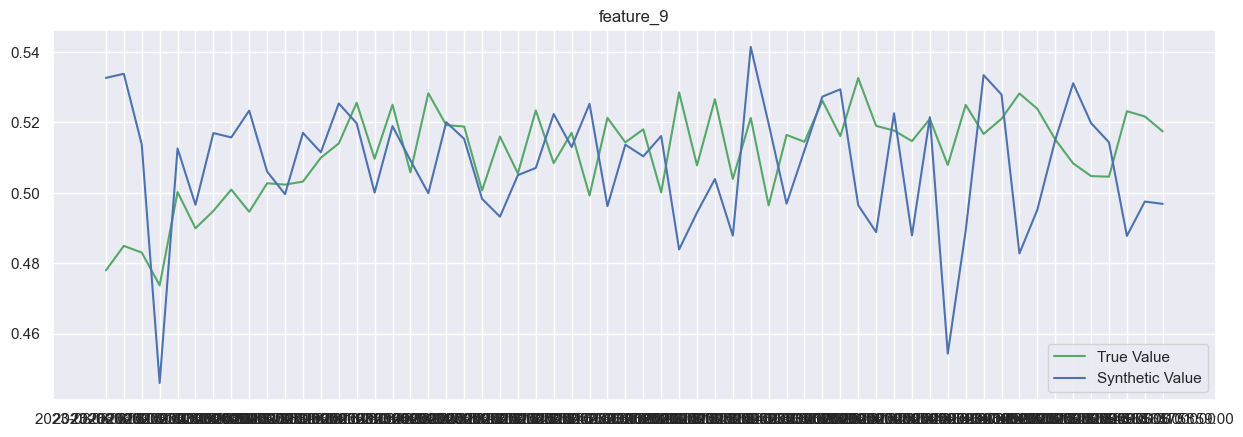

Overall Marginal Distribution Score: ./syn_location3_hours 5/location3_2023-08-06_hour01.csv 0.5762820512820512
Best Fidelity: feature_9 with fidelity: 0.925


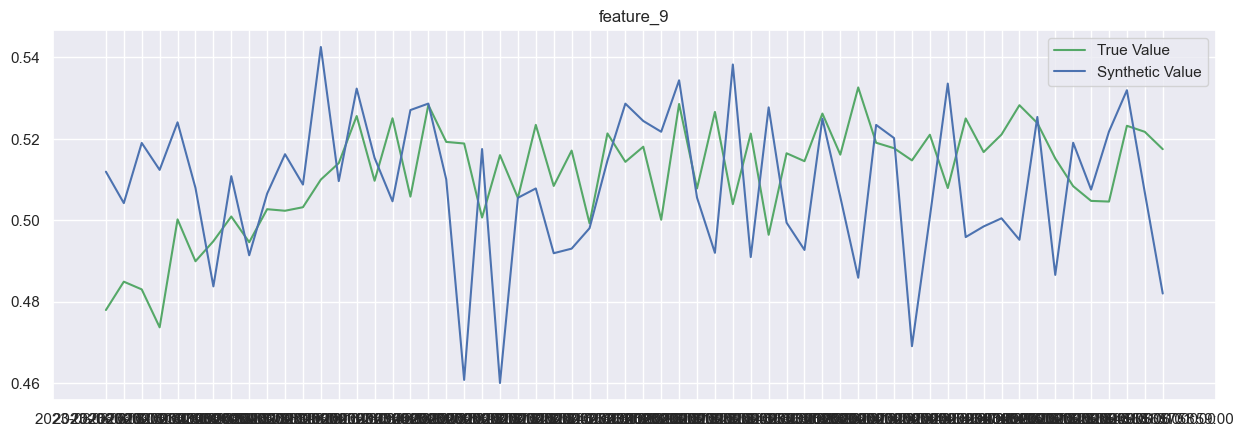

Overall Marginal Distribution Score: ./syn_location3_hours 2/location3_2023-08-06_hour01.csv 0.5871794871794871
Best Fidelity: feature_9 with fidelity: 0.9083333333333334


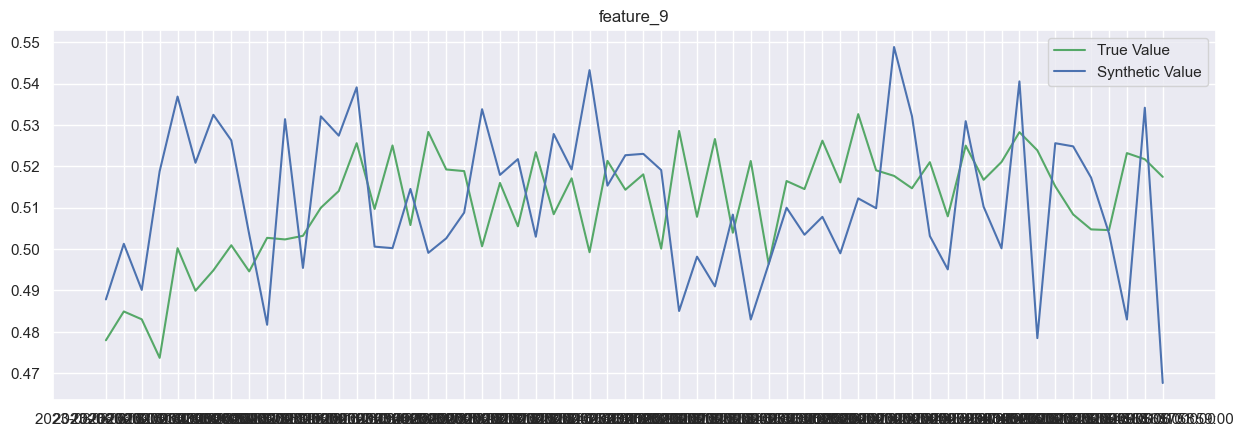

Overall Marginal Distribution Score: ./syn_location3_hours 3/location3_2023-08-06_hour01.csv 0.6070512820512822
Best Fidelity: feature_12 with fidelity: 0.9166666666666666


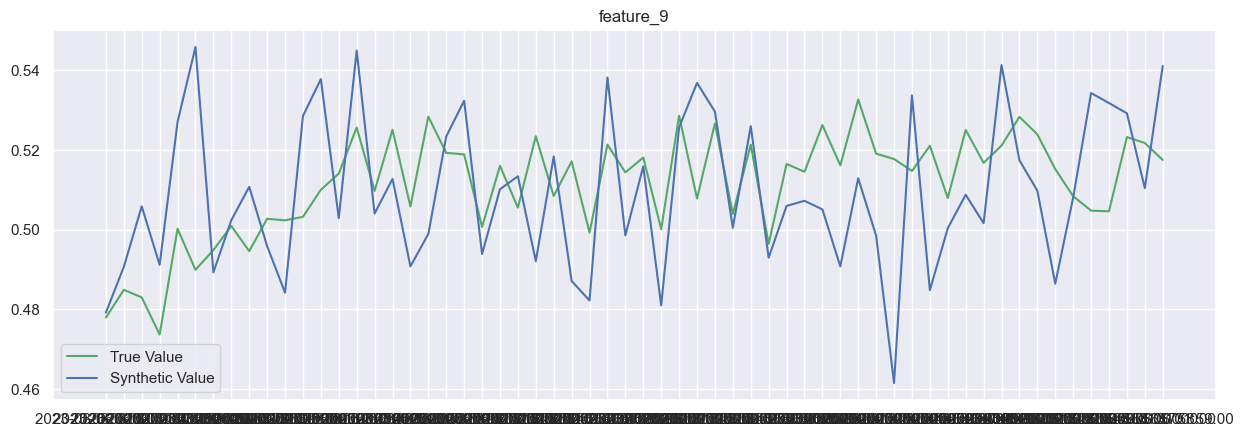

Overall Marginal Distribution Score: ./syn_location3_hours 4/location3_2023-08-06_hour01.csv 0.573076923076923
Best Fidelity: feature_9 with fidelity: 0.9083333333333333


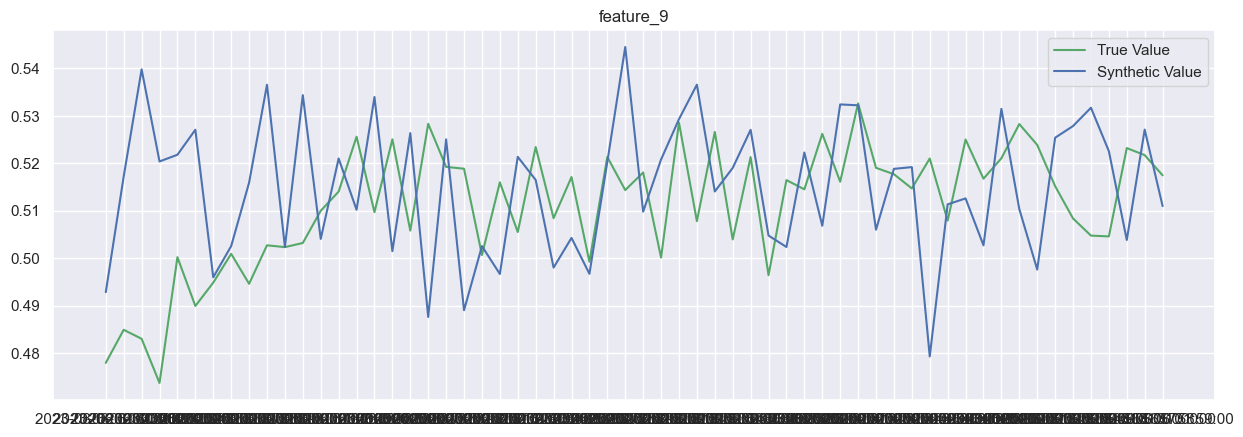

In [164]:
items = glob.glob('./syn_location3_hours [0-9]/location3_2023-08-06_hour01.csv')
fidelity_features = {i.split('/')[1]: None for i in items}
for i in items:
    _, bf = generate_reports('location3_hours/location3_2023-08-06_hour01.csv', i, show_plot=True, show_report=False, compute_best_feat=True, interested_features=[9])
    fidelity_features[i.split('/')[1]] = bf

In [71]:
[(k,x['feature_9']) for k,x in fidelity_features.items()]

[('syn_location3_hours 6', 0.8916666666666666),
 ('syn_location3_hours 5', 0.925),
 ('syn_location3_hours 2', 0.9083333333333334),
 ('syn_location3_hours 3', 0.9),
 ('syn_location3_hours 4', 0.9083333333333333)]

In [256]:
def sorter(x):
    x = x.split('.')[-2]
    try:
        x= int(x.split('to')[-1])
    except:
        x = int(x.split('_')[-1])
    return x

In [257]:
globber = glob.glob('./loc3_syn_tabgan_*.csv')
globber.sort(key=sorter)
globber

['./loc3_syn_tabgan_0to29.csv',
 './loc3_syn_tabgan_30to59.csv',
 './loc3_syn_tabgan_60to79.csv',
 './loc3_syn_tabgan_80to99.csv',
 './loc3_syn_tabgan_100to119.csv',
 './loc3_syn_tabgan_120to150.csv',
 './loc3_syn_tabgan_150to179.csv',
 './loc3_syn_tabgan_180to199.csv',
 './loc3_syn_tabgan_200.csv']

In [258]:
df=pd.concat([pd.read_csv(i) for i in globber])

In [259]:
df.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'timestamp'],
      dtype='object')

In [260]:
df.reset_index(inplace=True)

In [261]:
df.duplicated(subset='timestamp').any()

False

In [262]:
df.to_csv('new_syn.csv', index=False)

In [263]:
len(df)

12898

In [264]:
df.timestamp.max()

'2023-08-13 22:59:00'

In [269]:
globule = glob.glob('./location3_hours/location3_2023-08-[01][0-9]_hour[0-9][0-9].csv')
# globule2 = glob.glob('./location3_hours/location3_2023-08-1[0-1]_hour[0-9][0-9].csv')
# globule3 = glob.glob('./location3_hours/location3_2023-08-12_hour[0][0-9].csv')
# globule4 = glob.glob('./location3_hours/location3_2023-08-12_hour[1][01].csv')
# globule += globule2 + globule3 + globule4
globule.sort()
globule.pop()
globule.pop()
globule

['./location3_hours/location3_2023-08-05_hour00.csv',
 './location3_hours/location3_2023-08-05_hour01.csv',
 './location3_hours/location3_2023-08-05_hour02.csv',
 './location3_hours/location3_2023-08-05_hour03.csv',
 './location3_hours/location3_2023-08-05_hour04.csv',
 './location3_hours/location3_2023-08-05_hour05.csv',
 './location3_hours/location3_2023-08-05_hour06.csv',
 './location3_hours/location3_2023-08-05_hour07.csv',
 './location3_hours/location3_2023-08-05_hour08.csv',
 './location3_hours/location3_2023-08-05_hour09.csv',
 './location3_hours/location3_2023-08-05_hour10.csv',
 './location3_hours/location3_2023-08-05_hour11.csv',
 './location3_hours/location3_2023-08-05_hour12.csv',
 './location3_hours/location3_2023-08-05_hour13.csv',
 './location3_hours/location3_2023-08-05_hour14.csv',
 './location3_hours/location3_2023-08-05_hour15.csv',
 './location3_hours/location3_2023-08-05_hour16.csv',
 './location3_hours/location3_2023-08-05_hour17.csv',
 './location3_hours/location

In [270]:
real_df = pd.concat([pd.read_csv(i) for i in globule])

In [271]:
len(real_df)

12898

In [272]:
real_df.reset_index(inplace=True)

In [273]:
real_df['timestamp'] = df['timestamp']

In [274]:
real_df.to_csv('new_real.csv', index=False)

In [275]:
generate_reports('new_real.csv', 'new_syn.csv',False, interested_features=[9], has_timestamp=True, compute_best_feat=True)

Overall Marginal Distribution Score: new_syn.csv 0.9146149560942552
Best Fidelity: feature_9 with fidelity: 0.9806946813459451


(0.9146149560942552,
 {'feature_0': 0.977050705535742,
  'feature_1': 0.9589083578849434,
  'feature_2': 0.9659637153046984,
  'feature_3': 0.9635602418979687,
  'feature_4': 0.9579004496821213,
  'feature_5': 0.9706155993177237,
  'feature_6': 0.9495270584586758,
  'feature_7': 0.9494495270584586,
  'feature_8': 0.9780586137385641,
  'feature_9': 0.9806946813459451,
  'feature_10': 0.9626298650953636,
  'feature_11': 0.9535586912699643,
  'feature_12': 0.8840905566754536,
  'feature_13': 0.9011474647232129,
  'feature_14': 0.9063420685377578,
  'feature_15': 0.9588308264847263,
  'feature_16': 0.9736393239261901,
  'feature_17': 0.9457280198480384,
  'feature_18': 0.9689099085129478,
  'feature_19': 0.9568925414792991,
  'feature_20': 0.9138626143588153,
  'feature_21': 0.8136145138781207,
  'feature_22': 0.9637928360986199,
  'feature_23': 0.9799193673437743,
  'feature_24': 0.918049309970538})

In [118]:
80*60

4800

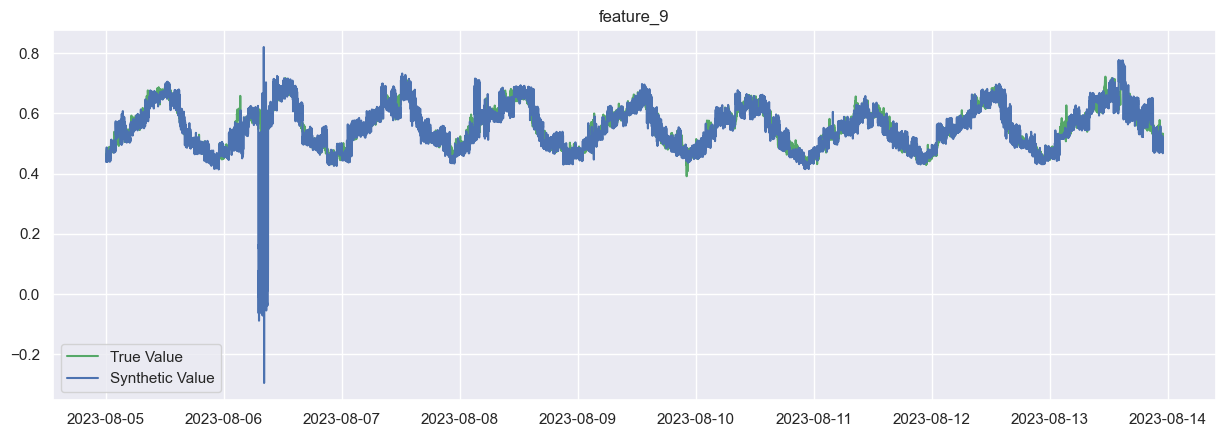

In [276]:
feature = f'feature_{9}'
source_data = rf.Dataset.from_csv('source','new_real.csv')
syn_data = rf.Dataset.from_csv('syun', 'new_syn.csv')
fig, ax = plt.subplots()
fig.set_figwidth(15)
x = source_data.table["timestamp"]
y1 = source_data.table[feature]
y2 = syn_data.table[feature]

min_len = min(len(x), len(y1), len(y2))

x = x[-min_len:]
y1 = y1[-min_len:]
y2 = y2[-min_len:]

if False:
    x = pd.to_datetime(x)
    x = x.astype(np.int64) // 10**9

ax.plot(x, y1, "g", label="True Value")
ax.plot(x, y2, "b", label="Synthetic Value")

# Calculate and plot the linear regression line for the true values
# change x to units
if False:
    coeffs_true = np.polyfit(x, y1, 1)
    linear_fit_true = np.poly1d(coeffs_true)
    ax.plot(x, linear_fit_true(x), "g--", label="True Value Linear Fit")
    
    # Calculate and plot the linear regression line for the synthetic values
    coeffs_syn = np.polyfit(x, y2, 1)
    linear_fit_syn = np.poly1d(coeffs_syn)
    ax.plot(x, linear_fit_syn(x), "b--", label="Synthetic Value Linear Fit")

plt.title(feature)
plt.legend()
plt.show()
